### Project python Code

In [ ]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


In [3]:

df=pd.read_csv("mtbs_tropical_annotations.tsv", sep="\t")

#take the interested columns and make a new dataframe cleaned
df_cleaned= df_small = df[[
    "structure_smiles",
    "structure_taxonomy_npclassifier_01pathway",
    "structure_taxonomy_npclassifier_02superclass",
    "structure_taxonomy_npclassifier_03class"
]]


#remove rows with missing structure_smiles
df_cleaned = df.dropna(subset=["structure_smiles"], axis=0)

#check for duplicated smiles
df_cleaned.duplicated(subset=["structure_smiles"]).sum()

#collapse duplicate smiles by taking the most common class, subclass, my_class
def take_most_common(series: pd.Series):
    s = series.dropna()
    if s.empty:
        return np.nan
    return s.value_counts().idxmax()

#rename columns for easier handling
df_cleaned = df_cleaned.rename(columns={
    "structure_smiles": "smiles",
    "structure_taxonomy_npclassifier_01pathway": "class",
    "structure_taxonomy_npclassifier_02superclass": "subclass",
    "structure_taxonomy_npclassifier_03class": "my_class"
})

#collapse duplicates
df_collapsed = (
    df_cleaned
    .groupby("smiles", as_index=False)[["class", "subclass", "my_class"]]
    .agg(take_most_common)
)

#now I give an id to each smiles as in R code 
df_collapsed["SID"] = ["S" + str(i+1) for i in range(len(df_collapsed))]
df_collapsed = df_collapsed[["SID", "smiles", "class", "subclass", "my_class"]]


#calculate chemical descriptors
def calc_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "RingCount": Descriptors.RingCount(mol),
        "FractionCSP3": Descriptors.FractionCSP3(mol)
    }

desc_list = df_collapsed["smiles"].apply(calc_desc)
desc_df = pd.DataFrame(desc_list.tolist())
df_final = pd.concat([df_collapsed, desc_df], axis=1)




In [4]:
#export final dataframe to csv
df_final.to_csv("mtbs_tropical_descriptors.csv", index=False)

In [5]:
df_final.head()

SID                               smiles        class  \
0  S1   C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C  Fatty acids   
1  S2          C#C/C=C\CCCC#CCCCCCCCCCCC#C  Fatty acids   
2  S3       C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO  Fatty acids   
3  S4  C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1    Alkaloids   
4  S5                   C#CC#CC=CC=CC=CCCO  Fatty acids   

                                 subclass  \
0                             Fatty acyls   
1  Fatty acyls|Fatty Acids and Conjugates   
2                             Fatty acyls   
3                        Lysine alkaloids   
4              Fatty Acids and Conjugates   

                                 my_class    MolWt    LogP   TPSA  HBD  HBA  \
0                          Fatty alcohols  292.466  5.8258   0.00    0    0   
1  Fatty alcohols|Unsaturated fatty acids  282.471  5.8837   0.00    0    0   
2                          Fatty alcohols  308.465  4.4694  20.23    1    1   
3                    Piperidine alkaloids  297.442  4.0885  20.31    0    1   
4                 Unsaturated fatty acids  172.227  1.6740  20.23    1    1   

   RingCount  FractionCSP3  
0          0      0.454545  
1          0      0.619048  
2          0      0.545455  
3          1      0.550000  
4          0      0.166667

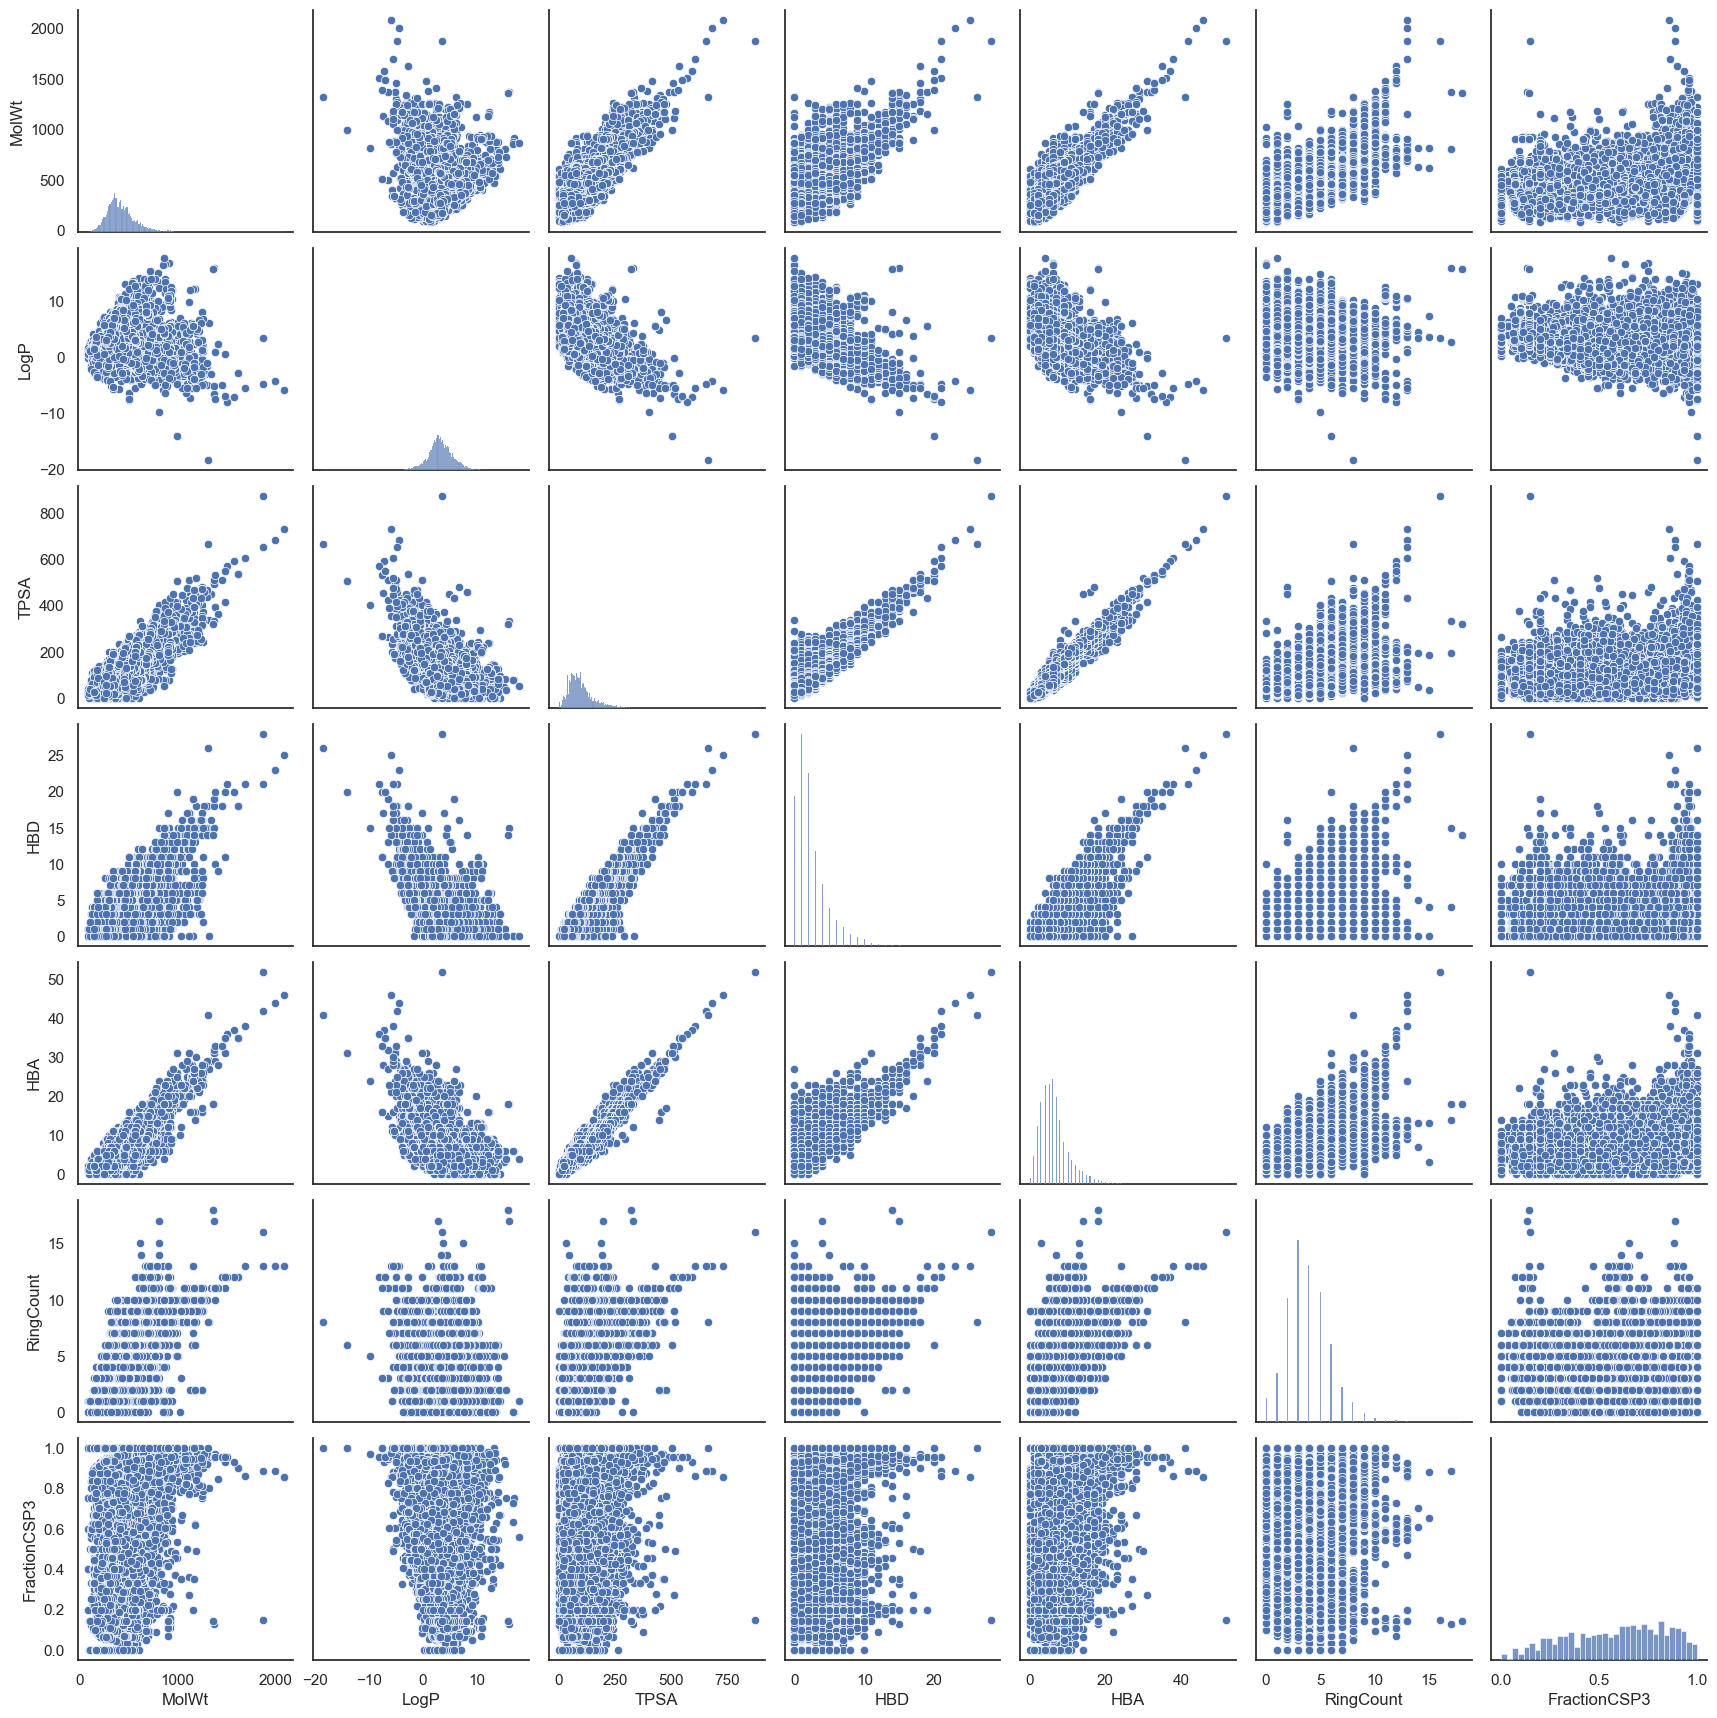

In [6]:
sns.pairplot(df_final)


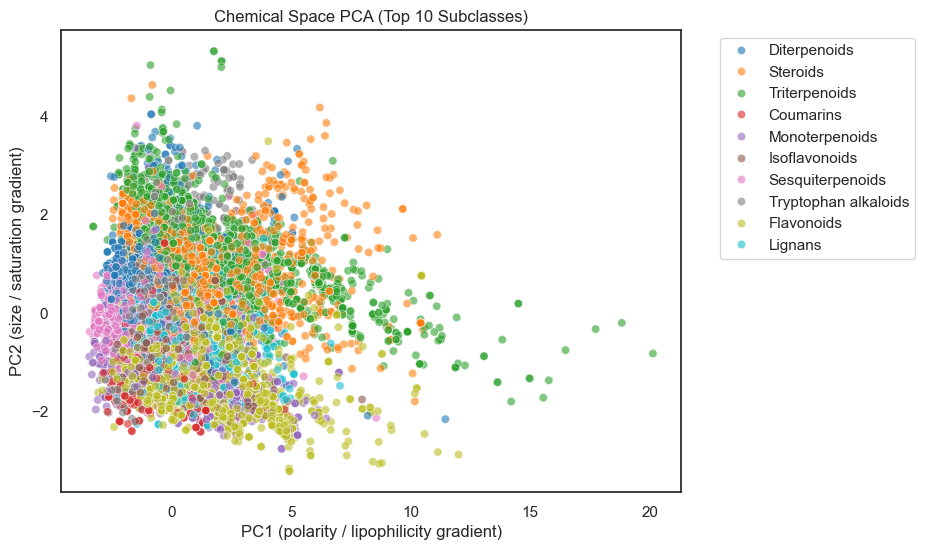

In [44]:
#PCA analysis and plot

# 1) select numeric descriptor columns
desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RingCount", "FractionCSP3"]
X = df_final[desc_cols].dropna()

# 2) scale descriptors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) run PCA
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# 4) add PC1 and PC2 back to df_final (align with X index)
df_final.loc[X.index, "PC1"] = pcs[:, 0]
df_final.loc[X.index, "PC2"] = pcs[:, 1]



# I pick top 10 most common subclasses 
# i didn't select all bc too many and if I select on my own it may be biased
top_sub = df_final["subclass"].value_counts().index[:10]

df_top = df_final[df_final["subclass"].isin(top_sub)]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_top,
    x="PC1", y="PC2",
    hue="subclass",
    alpha=0.6,
    palette="tab10"
)
plt.xlabel("PC1 (polarity / lipophilicity gradient)")
plt.ylabel("PC2 (size / saturation gradient)")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Chemical Space PCA (Top 10 Subclasses)")
plt.show()


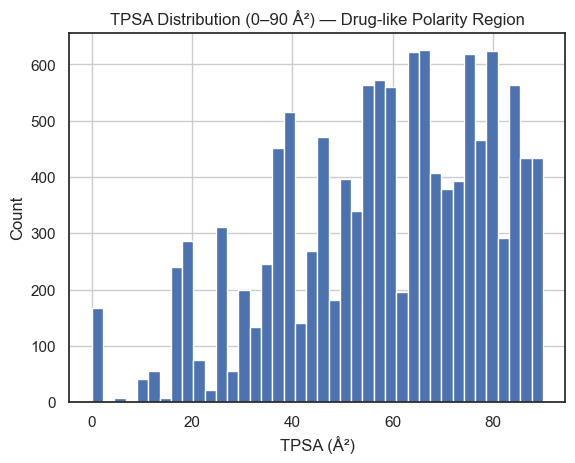

In [8]:
#TPSA = Topological Polar Surface Area a indicator of overall polarity.
#Most medicinal chemistry papers visualize TPSA in the 0–90 Å² region.
#TPSA < 90 Å² is the “sweet spot” for
# cell-membrane permeability
#  oral absorption
#  drug-likeness
df_tpsa = df_final[df_final["TPSA"] <= 90]

df_tpsa["TPSA"].hist(bins=40)
plt.xlabel("TPSA (Å²)")
plt.ylabel("Count")
plt.title("TPSA Distribution (0–90 Å²) — Drug-like Polarity Region",loc="center")
plt.show()




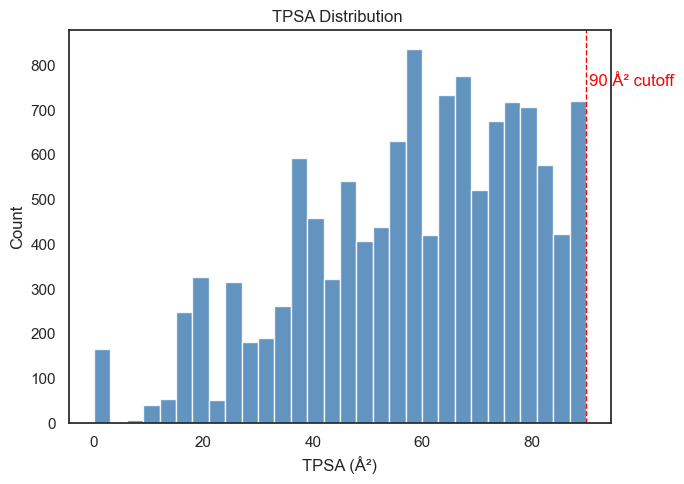

In [9]:
df_tpsa = df_final[df_final["TPSA"] <= 90]

plt.figure(figsize=(7,5))

counts, bins, patches = plt.hist(
    df_tpsa["TPSA"],
    bins=30,
    color="steelblue",
    alpha=0.85,
    edgecolor="white"
)

# Drug-likeness cutoff
plt.axvline(90, color="red", linestyle="--", linewidth=1)
plt.text(90.5, counts.max()*0.9, "90 Å² cutoff", color="red")

plt.xlabel("TPSA (Å²)")
plt.ylabel("Count")
plt.title("TPSA Distribution ")


plt.tight_layout()
plt.show()


In [10]:
df_final.head()

SID                               smiles        class  \
0  S1   C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C  Fatty acids   
1  S2          C#C/C=C\CCCC#CCCCCCCCCCCC#C  Fatty acids   
2  S3       C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO  Fatty acids   
3  S4  C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1    Alkaloids   
4  S5                   C#CC#CC=CC=CC=CCCO  Fatty acids   

                                 subclass  \
0                             Fatty acyls   
1  Fatty acyls|Fatty Acids and Conjugates   
2                             Fatty acyls   
3                        Lysine alkaloids   
4              Fatty Acids and Conjugates   

                                 my_class    MolWt    LogP   TPSA  HBD  HBA  \
0                          Fatty alcohols  292.466  5.8258   0.00    0    0   
1  Fatty alcohols|Unsaturated fatty acids  282.471  5.8837   0.00    0    0   
2                          Fatty alcohols  308.465  4.4694  20.23    1    1   
3                    Piperidine alkaloids  297.442  4.0885  20.31    0    1   
4                 Unsaturated fatty acids  172.227  1.6740  20.23    1    1   

   RingCount  FractionCSP3       PC1       PC2  
0          0      0.454545 -3.250702 -0.046519  
1          0      0.619048 -3.214056  0.255949  
2          0      0.545455 -2.613569 -0.357019  
3          1      0.550000 -2.607186 -0.190120  
4          0      0.166667 -2.897674 -2.104791

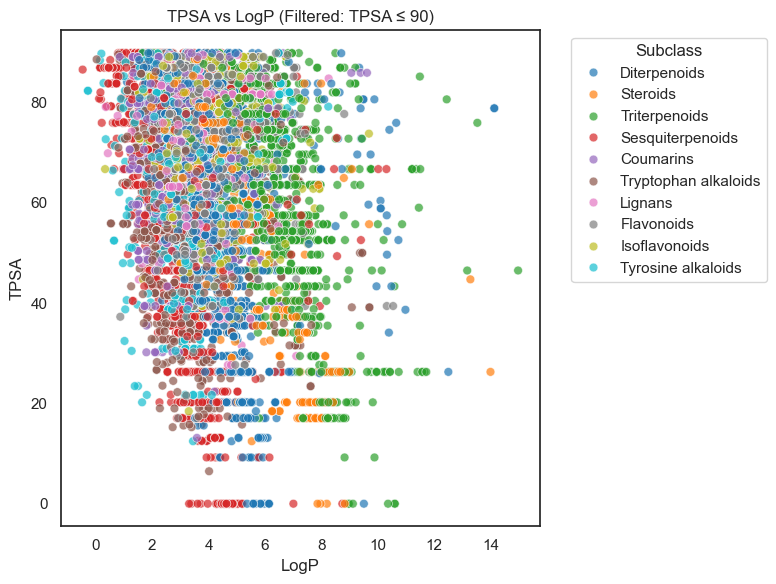

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# 1. Filter dataset: keep only TPSA ≤ 90
# ------------------------------------------------
df_tpsa = df_final[df_final["TPSA"] <= 90].copy()

# (Optional) keep only top subclasses
top_sub = df_tpsa["subclass"].value_counts().index[:10]
df_tpsa = df_tpsa[df_tpsa["subclass"].isin(top_sub)]

# ------------------------------------------------
# 2. Scatter plot TPSA vs LogP
# ------------------------------------------------
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=df_tpsa,
    x="LogP",
    y="TPSA",
    hue="subclass",
    s=40,
    alpha=0.7,
    palette="tab10"
)

plt.xlabel("LogP")
plt.ylabel("TPSA")
plt.title("TPSA vs LogP (Filtered: TPSA ≤ 90)")

plt.legend(title="Subclass", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [12]:
df_plot = df_final[df_final["TPSA"] <= 90].copy()

top_sub = df_plot["subclass"].value_counts().index[:10]
df_plot = df_plot[df_plot["subclass"].isin(top_sub)]


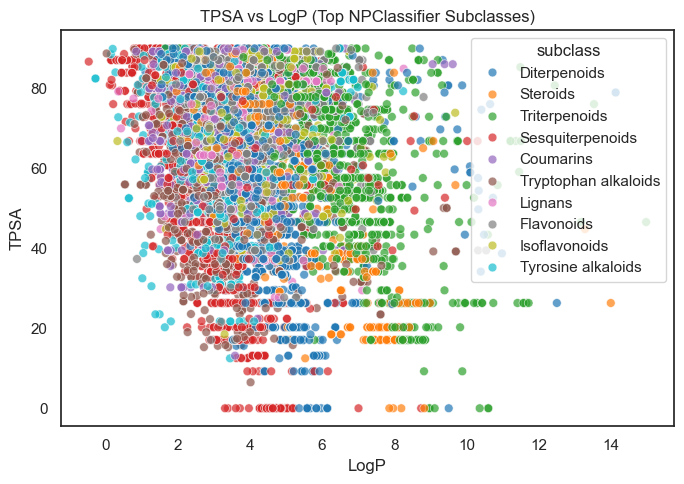

In [13]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_plot,
    x="LogP",
    y="TPSA",
    hue="subclass",
    s=40,
    alpha=0.7,
    palette="tab10"
)
plt.title("TPSA vs LogP (Top NPClassifier Subclasses)")
plt.tight_layout()
plt.show()


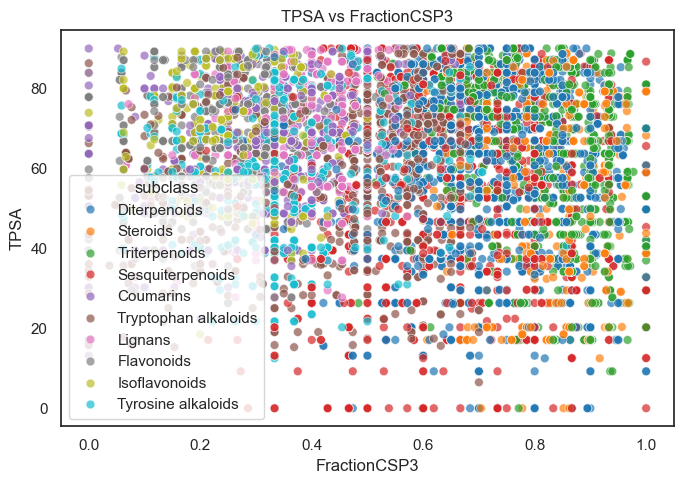

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_plot,
    x="FractionCSP3",
    y="TPSA",
    hue="subclass",
    s=40,
    alpha=0.7,
    palette="tab10"
)
plt.title("TPSA vs FractionCSP3")
plt.tight_layout()
plt.show()


/var/folders/nm/01cqfvgn1655c0dthf5dhh900000gn/T/ipykernel_5494/3805355339.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


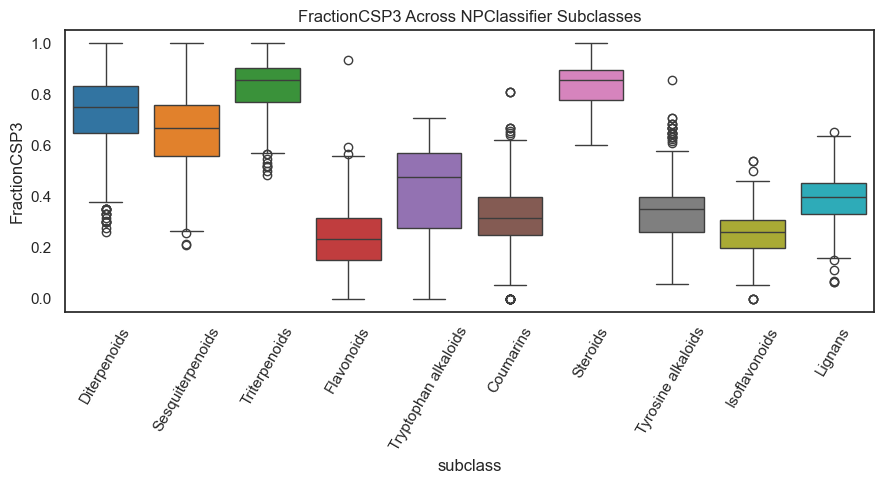

In [15]:
plt.figure(figsize=(9,5))
sns.boxplot(
    data=df_plot,
    x="subclass",
    y="FractionCSP3",
    order=top_sub,
    palette="tab10"
)
plt.xticks(rotation=60)
plt.title("FractionCSP3 Across NPClassifier Subclasses")
plt.tight_layout()
plt.show()


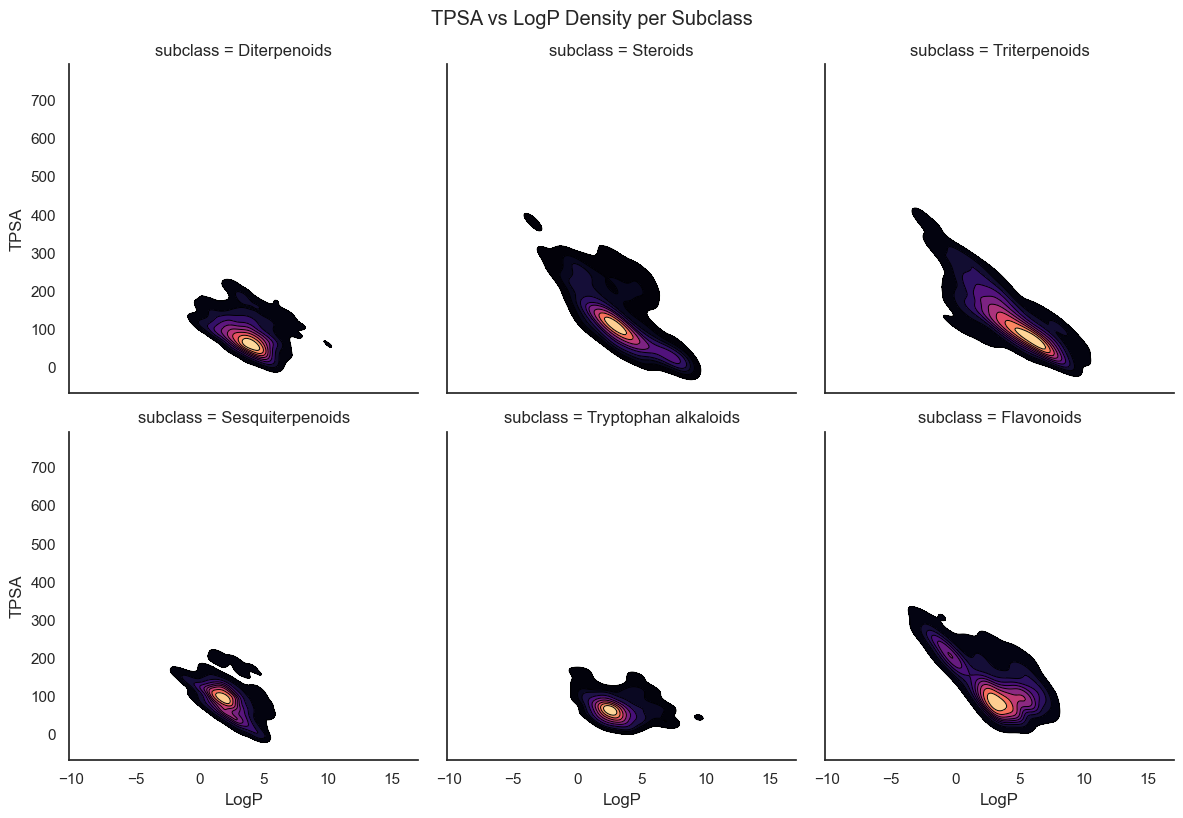

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

top_sub = df_final["subclass"].value_counts().index[:6]  # first 6 subclasses

g = sns.FacetGrid(df_final[df_final["subclass"].isin(top_sub)],
                  col="subclass", col_wrap=3, height=4)

g.map_dataframe(sns.kdeplot, x="LogP", y="TPSA", fill=True, cmap="magma")
g.map_dataframe(
    sns.kdeplot,
    x="LogP",
    y="TPSA",
    color="black",
    linewidths=0.7,
    levels=10
)
g.fig.suptitle("TPSA vs LogP Density per Subclass", y=1.02)
plt.show()


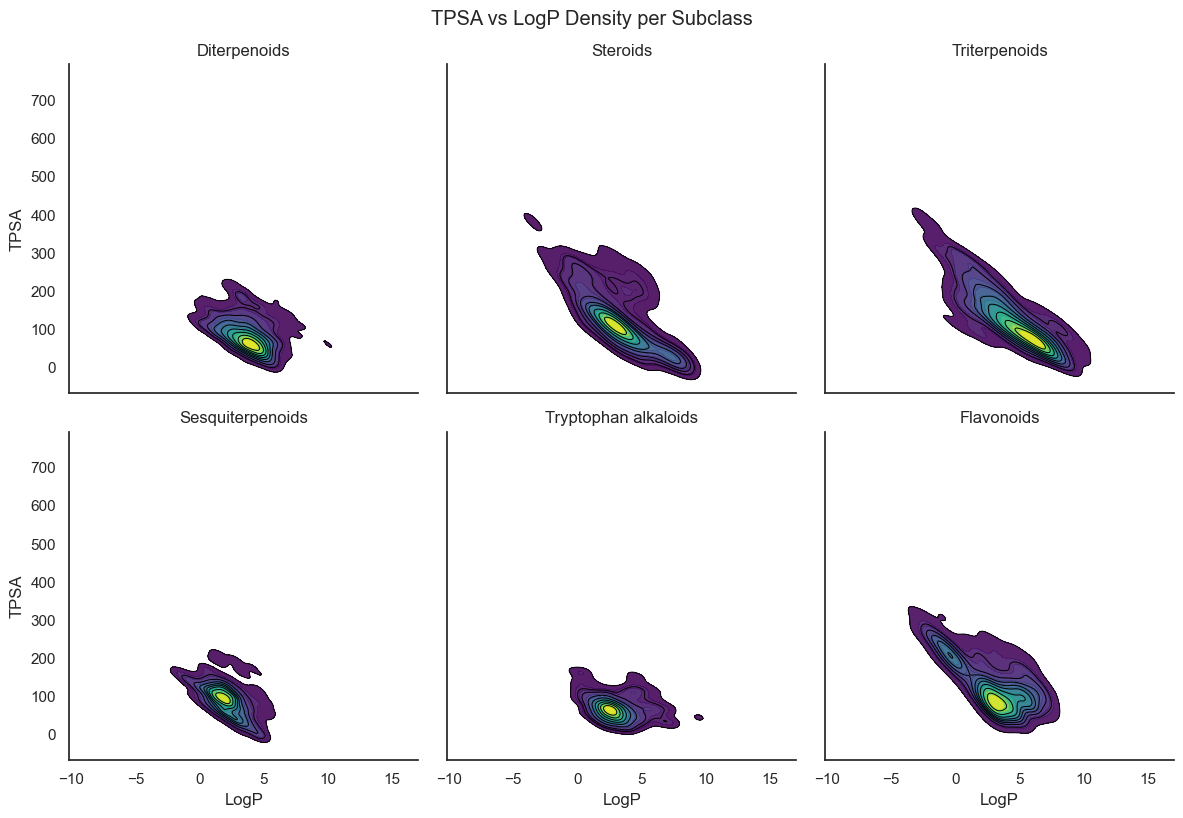

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")  # clean background

top_sub = df_final["subclass"].value_counts().index[:6]

g = sns.FacetGrid(
    df_final[df_final["subclass"].isin(top_sub)],
    col="subclass",
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)

# MAIN KDE (smooth, publication-ready)
g.map_dataframe(
    sns.kdeplot,
    x="LogP",
    y="TPSA",
    fill=True,
    cmap="viridis",
    levels=15,
    thresh=0.05,
    alpha=0.9
)

# ADD CONTOUR LINES for clarity
g.map_dataframe(
    sns.kdeplot,
    x="LogP",
    y="TPSA",
    color="black",
    linewidths=0.7,
    levels=10
)

# Titles & layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("LogP", "TPSA")
g.fig.suptitle("TPSA vs LogP Density per Subclass", y=1.02)

plt.show()


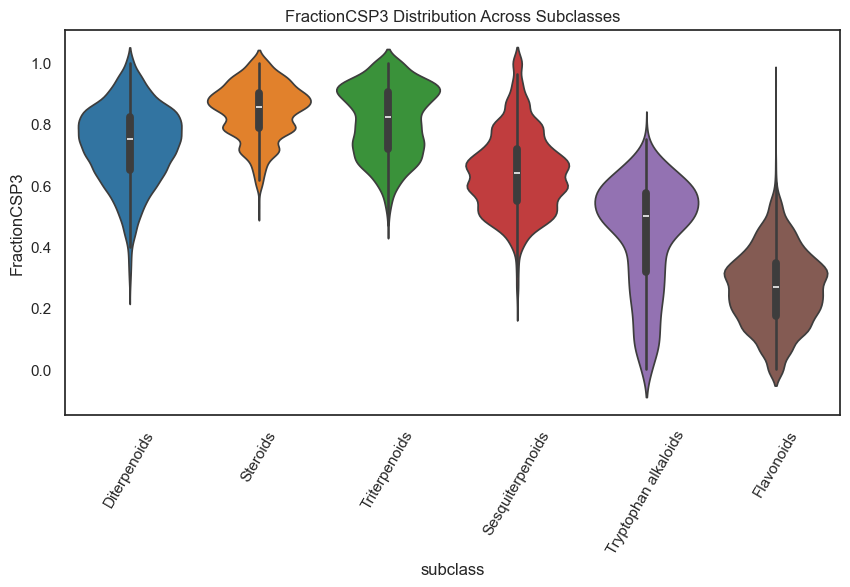

In [18]:
plt.figure(figsize=(10,5))
sns.violinplot(
    data=df_final[df_final["subclass"].isin(top_sub)],
    x="subclass",
    y="FractionCSP3",
    hue="subclass",        
    palette="tab10",
    legend=False      
)
plt.xticks(rotation=60)
plt.title("FractionCSP3 Distribution Across Subclasses")
plt.show()


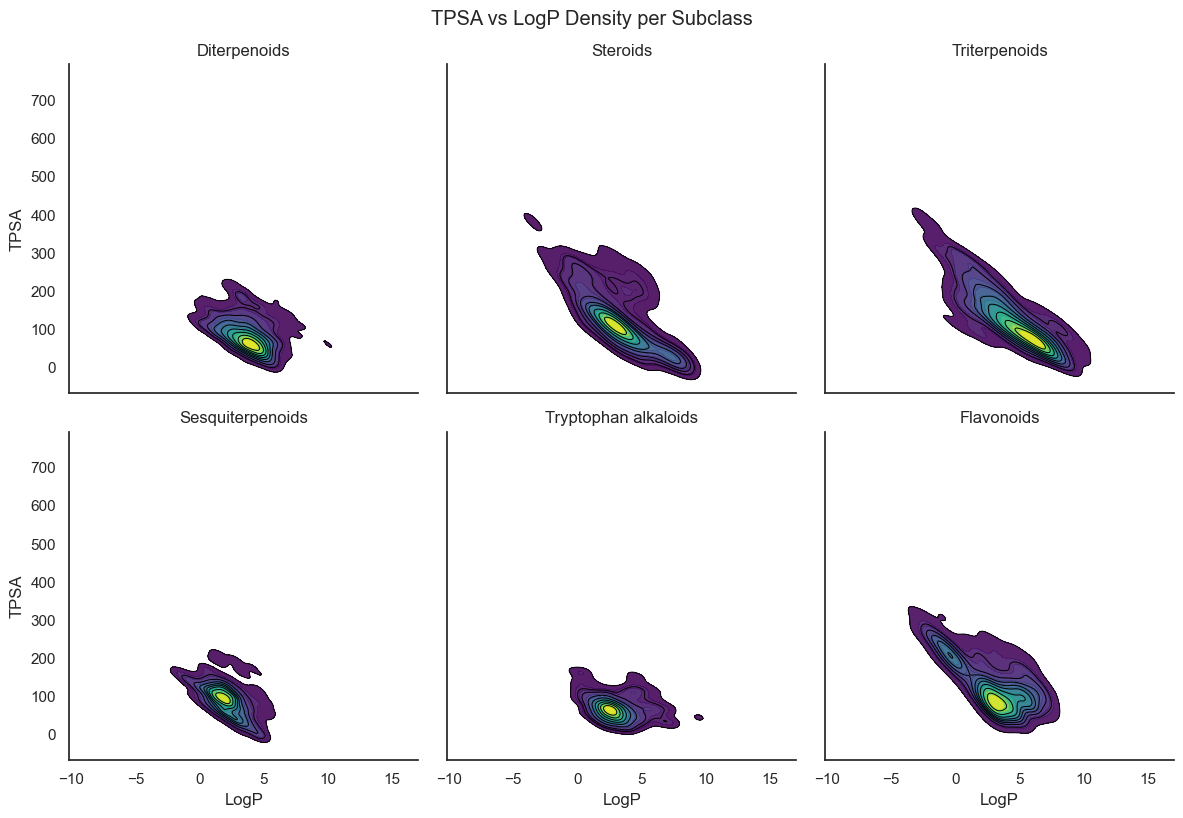

In [19]:
#plotting TPSA vs LogP density plots for top 6 subclasses with improved aesthetics
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_theme(style="white")  # clean background
g = sns.FacetGrid(
    df_final[df_final["subclass"].isin(top_sub)],
    col="subclass",
    col_wrap=3,
    height=4,
    sharex=True,
    sharey=True
)
# MAIN KDE (smooth, publication-ready)
g.map_dataframe(
    sns.kdeplot,
    x="LogP",
    y="TPSA",
    fill=True,
    cmap="viridis",
    levels=15,
    thresh=0.05,
    alpha=0.9
)
# ADD CONTOUR LINES for clarity
g.map_dataframe(
    sns.kdeplot,
    x="LogP",
    y="TPSA",
    color="black",
    linewidths=0.7,
    levels=10
)
# Titles & layout
g.set_titles(col_template="{col_name}")
g.set_axis_labels("LogP", "TPSA")
g.fig.suptitle("TPSA vs LogP Density per Subclass", y=1.02)
plt.show()


In [20]:
import numpy as np
import pandas as pd

# 1) pick some subclasses (here: top 10 by count)
top_sub = df_final["subclass"].value_counts().index[:10]

df_sub = df_final[df_final["subclass"].isin(top_sub)].copy()

# 2) sample up to 50 molecules per subclass for plotting
#    (if a subclass has <50, it keeps all of them)
df_plot = (
    df_sub
    .groupby("subclass", group_keys=False)
    .apply(lambda x: x.sample(n=min(50, len(x)), random_state=0))
)

print(df_plot["subclass"].value_counts())


subclass
Coumarins               50
Diterpenoids            50
Flavonoids              50
Isoflavonoids           50
Lignans                 50
Monoterpenoids          50
Sesquiterpenoids        50
Steroids                50
Triterpenoids           50
Tryptophan alkaloids    50
Name: count, dtype: int64


/var/folders/nm/01cqfvgn1655c0dthf5dhh900000gn/T/ipykernel_5494/539296616.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(50, len(x)), random_state=0))


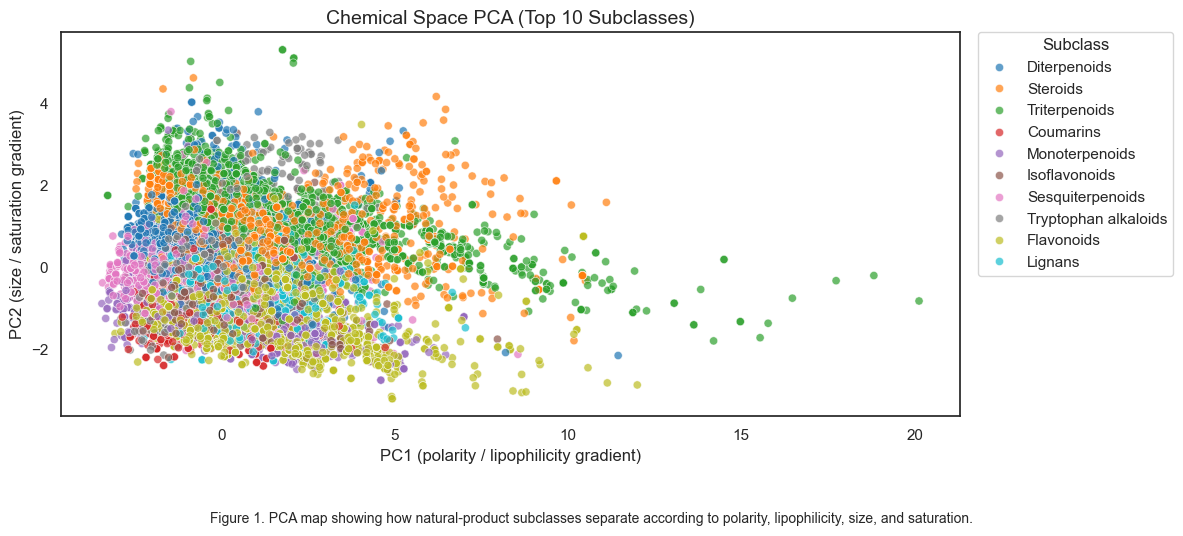

In [50]:
# --- PCA of molecular descriptors and chemical space plot ---

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

sns.set_theme(style="white")

# 1) Select numeric descriptor columns
desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RingCount", "FractionCSP3"]
X = df_final[desc_cols].dropna()

# 2) Scale descriptors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3) Run PCA (2 components)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# 4) Add PC1 and PC2 back to a working DataFrame aligned with X
df_pca = df_final.loc[X.index].copy()
df_pca["PC1"] = pcs[:, 0]
df_pca["PC2"] = pcs[:, 1]

# 5) Keep only top 10 most common NPClassifier subclasses
top_sub = df_pca["subclass"].value_counts().index[:10]
df_top = df_pca[df_pca["subclass"].isin(top_sub)].copy()

# 6) Plot PCA scatter
fig, ax = plt.subplots(figsize=(12, 5))
sns.scatterplot(
    data=df_top,
    x="PC1",
    y="PC2",
    hue="subclass",
    alpha=0.7,
    s=35,
    palette="tab10",
    ax=ax
)

ax.set_title("Chemical Space PCA (Top 10 Subclasses)", fontsize=14)
ax.set_xlabel("PC1 (polarity / lipophilicity gradient)")
ax.set_ylabel("PC2 (size / saturation gradient)")

# Place legend outside the plotting area on the right
ax.legend(
    title="Subclass",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.
)

# 7) Add caption under the figure
caption = (
    "Figure 1. PCA map showing how natural-product subclasses separate according to "
    "polarity, lipophilicity, size, and saturation."
)

fig.text(
    0.5, -0.04,
    caption,
    ha="center",
    va="top",
    fontsize=10,
    wrap=True
)

plt.tight_layout(rect=[0, 0.02, 1, 1])
plt.show()


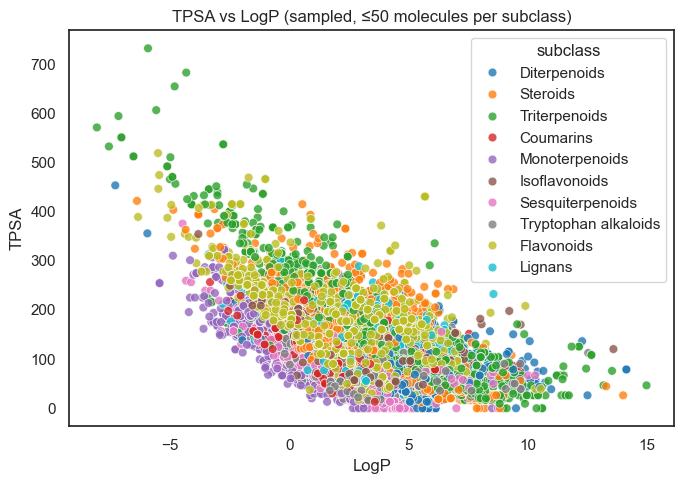

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df_plot,
    x="LogP",
    y="TPSA",
    hue="subclass",
    s=40,
    alpha=0.8,
    palette="tab10"
)
plt.title("TPSA vs LogP (sampled, ≤50 molecules per subclass)")

plt.tight_layout()
plt.show()


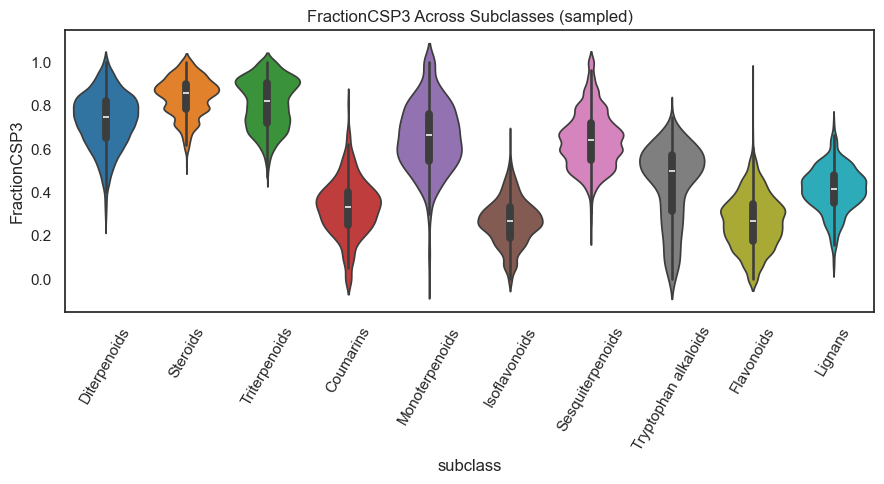

In [51]:
plt.figure(figsize=(9,5))
sns.violinplot(
    data=df_plot,
    x="subclass",
    y="FractionCSP3",
    hue="subclass",
    palette="tab10",
    legend=False
)
plt.xticks(rotation=60)
plt.title("FractionCSP3 Across Subclasses (sampled)")
plt.tight_layout()
plt.show()


/var/folders/nm/01cqfvgn1655c0dthf5dhh900000gn/T/ipykernel_5494/3821898378.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(50, len(x)), random_state=0))


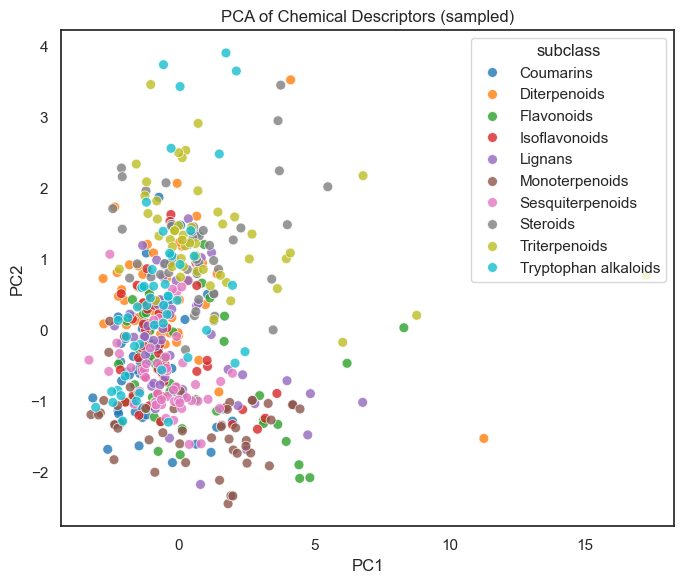

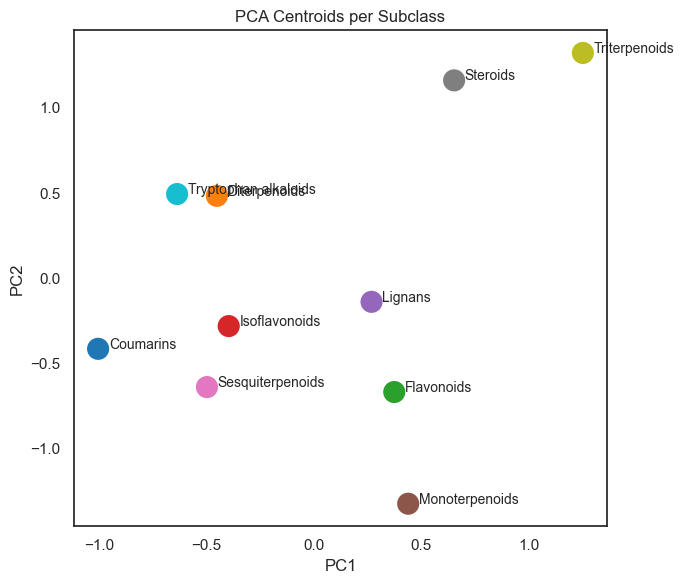

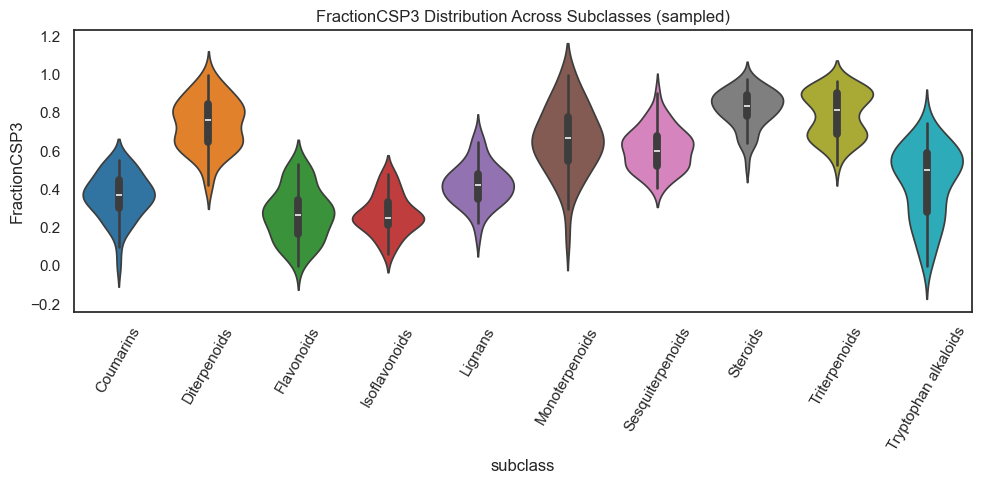

In [23]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Select subclasses and sample molecules ---
top_sub = df_final["subclass"].value_counts().index[:10]
df_sub = df_final[df_final["subclass"].isin(top_sub)].copy()

df_plot = (
    df_sub.groupby("subclass", group_keys=False)
    .apply(lambda x: x.sample(n=min(50, len(x)), random_state=0))
)

# --- 2. PCA ---
desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RingCount", "FractionCSP3"]
X = df_plot[desc_cols].dropna()

X_scaled = StandardScaler().fit_transform(X)
pcs = PCA(n_components=2).fit_transform(X_scaled)

df_pca = df_plot.loc[X.index].copy()
df_pca["PC1"], df_pca["PC2"] = pcs[:,0], pcs[:,1]

# --- 3. PCA scatter (sampled) ---
plt.figure(figsize=(7,6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2",
                hue="subclass", palette="tab10", s=50, alpha=0.8)
plt.title("PCA of Chemical Descriptors (sampled)")
plt.tight_layout()
plt.show()

# --- 4. PCA centroids ---
cent = df_pca.groupby("subclass")[["PC1","PC2"]].mean()
plt.figure(figsize=(7,6))
sns.scatterplot(x=cent["PC1"], y=cent["PC2"],
                hue=cent.index, palette="tab10", s=300, legend=False)
for name, r in cent.iterrows():
    plt.text(r["PC1"]+0.05, r["PC2"], name, fontsize=10)
plt.title("PCA Centroids per Subclass")
plt.tight_layout()
plt.show()

# --- 5. Violin plot (sampled) ---
plt.figure(figsize=(10,5))
sns.violinplot(data=df_plot, x="subclass", y="FractionCSP3",
               hue="subclass", palette="tab10", legend=False)
plt.xticks(rotation=60)
plt.title("FractionCSP3 Distribution Across Subclasses (sampled)")
plt.tight_layout()
plt.show()


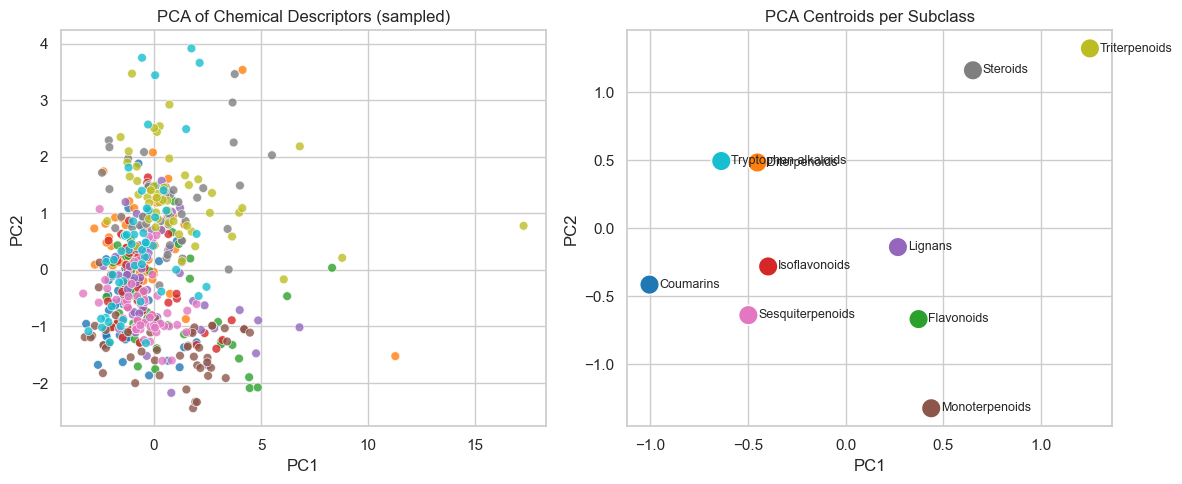

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# df_pca: contains columns ["PC1", "PC2", "subclass"]
# cent: centroids = df_pca.groupby("subclass")[["PC1","PC2"]].mean()

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left panel: PCA scatter (sampled points) ---
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="subclass",
    palette="tab10",
    s=40,
    alpha=0.8,
    ax=axes[0]
)
axes[0].set_title("PCA of Chemical Descriptors (sampled)")
axes[0].legend_.remove()  # remove legend here to avoid duplication

# --- Right panel: PCA centroids ---
sns.scatterplot(
    x=cent["PC1"],
    y=cent["PC2"],
    hue=cent.index,
    palette="tab10",
    s=200,
    ax=axes[1],
    legend=False
)

for name, row in cent.iterrows():
    axes[1].text(
        row["PC1"] + 0.05,
        row["PC2"],
        name,
        fontsize=9,
        va="center"
    )

axes[1].set_title("PCA Centroids per Subclass")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()


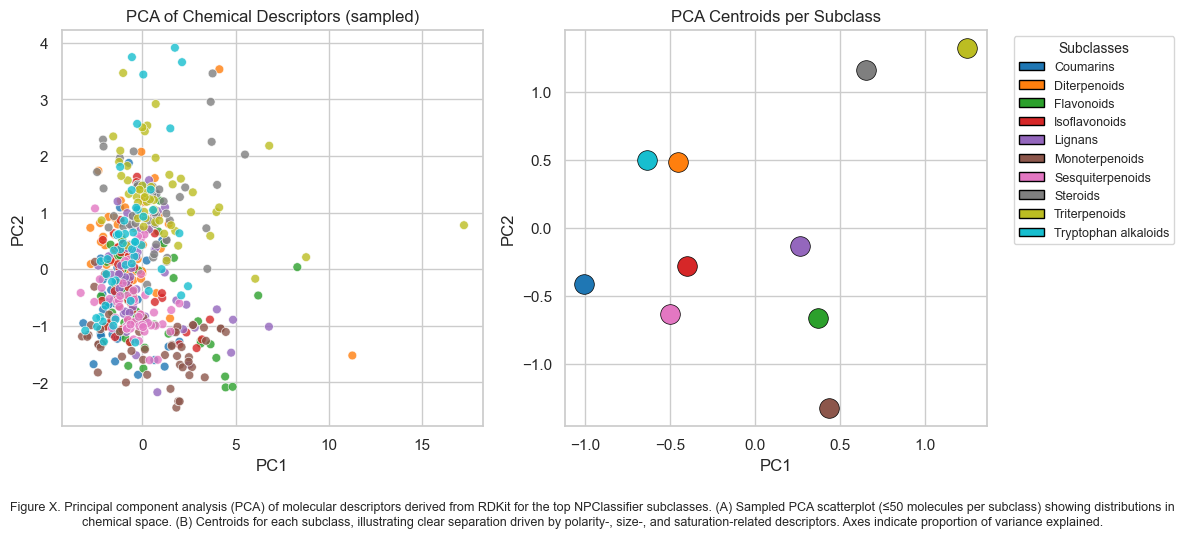

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Choose palette manually so we can reuse exact colors in legend
palette = sns.color_palette("tab10", n_colors=len(cent.index))
color_map = dict(zip(cent.index, palette))

# -----------------------------------
# Left panel: PCA scatter (sampled)
# -----------------------------------
sns.scatterplot(
    data=df_pca,
    x="PC1",
    y="PC2",
    hue="subclass",
    palette=color_map,
    s=40,
    alpha=0.8,
    ax=axes[0]
)
axes[0].set_title("PCA of Chemical Descriptors (sampled)")
axes[0].legend_.remove()

# -----------------------------------
# Right panel: PCA centroids
# -----------------------------------
for subclass in cent.index:
    axes[1].scatter(
        cent.loc[subclass, "PC1"],
        cent.loc[subclass, "PC2"],
        s=200,
        color=color_map[subclass],
        edgecolor="black",
        linewidth=0.5
    )

axes[1].set_title("PCA Centroids per Subclass")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# -----------------------------------
# Legend box (manual but correct)
# -----------------------------------
legend_patches = [
    Patch(facecolor=color_map[s], edgecolor='black', label=s)
    for s in cent.index
]

axes[1].legend(
    handles=legend_patches,
    title="Subclasses",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)
caption = (
    "Figure X. Principal component analysis (PCA) of molecular descriptors derived "
    "from RDKit for the top NPClassifier subclasses. "
    "(A) Sampled PCA scatterplot (≤50 molecules per subclass) showing distributions "
    "in chemical space. "
    "(B) Centroids for each subclass, illustrating clear separation driven by "
    "polarity-, size-, and saturation-related descriptors. Axes indicate proportion "
    "of variance explained."
)

fig.text(
    0.5, -0.02,              # x, y position in figure coordinates
    caption,
    ha="center",
    va="top",
    fontsize=9,
    wrap=True
)

plt.tight_layout()
plt.show()


/var/folders/nm/01cqfvgn1655c0dthf5dhh900000gn/T/ipykernel_5494/3129458121.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


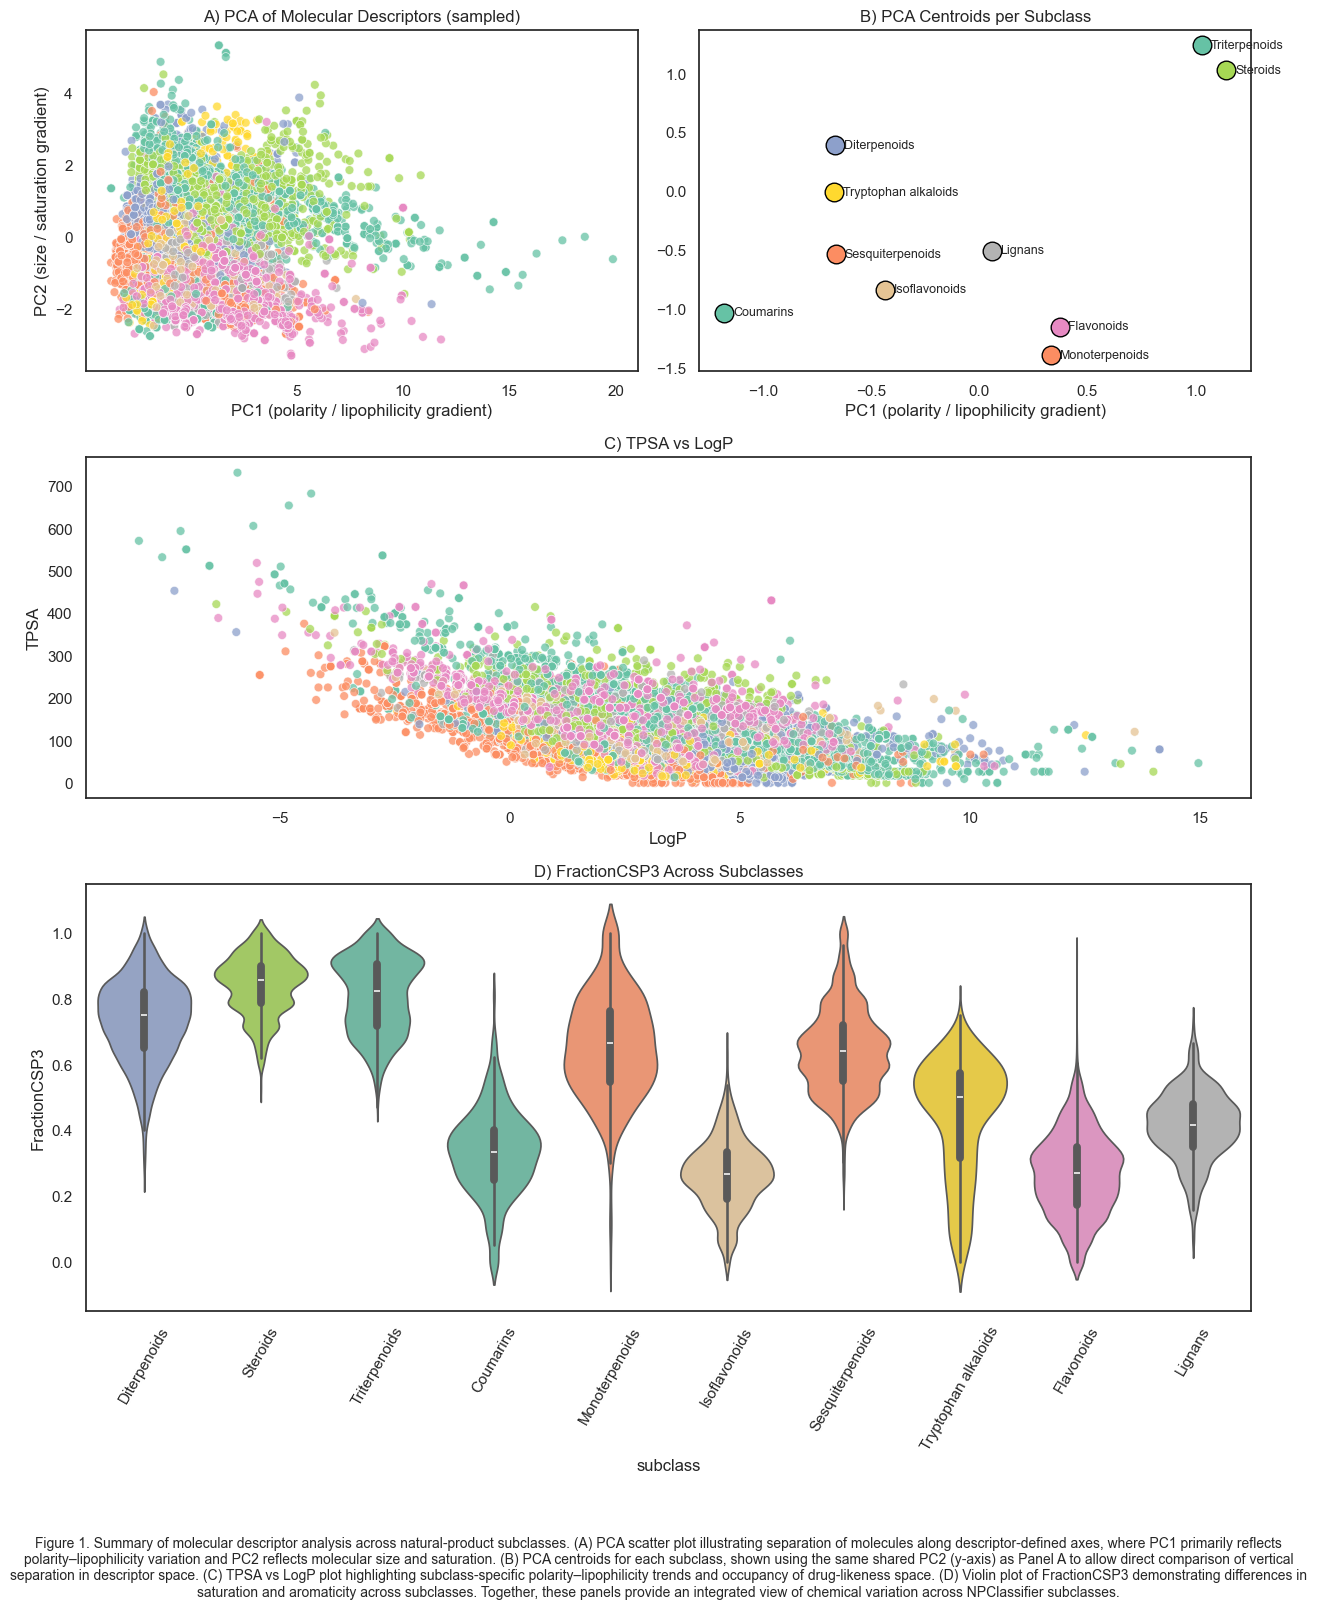

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

sns.set_theme(style="white")

# -------------------------------------------------------------------------
# 1) PREPARE COLORS
# -------------------------------------------------------------------------
top_sub = df_final["subclass"].value_counts().index[:10]
palette = sns.color_palette("Set2", n_colors=len(top_sub))
color_map = dict(zip(top_sub, palette))

# Subset for plotting
df_plot = df_final[df_final["subclass"].isin(top_sub)].copy()

# PCA prep
desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RingCount", "FractionCSP3"]
X = df_plot[desc_cols].dropna()

X_scaled = StandardScaler().fit_transform(X)
pcs = PCA(n_components=2).fit_transform(X_scaled)

df_pca = df_plot.loc[X.index].copy()
df_pca["PC1"], df_pca["PC2"] = pcs[:, 0], pcs[:, 1]
centroids = df_pca.groupby("subclass")[["PC1", "PC2"]].mean()

# -------------------------------------------------------------------------
# 2) SUMMARY FIGURE (A, B on top; C middle; D bottom)
# -------------------------------------------------------------------------
fig = plt.figure(figsize=(13, 15))

# Grid layout: 3 rows, 2 columns
# Row 1: A (left), B (right)
# Row 2: C (left, full width but using 2 panels visually aligned)
# Row 3: D (full-width violin)

gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 1.5])

# ---------------- Panel A — PCA scatter ----------------
axA = fig.add_subplot(gs[0, 0])
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axA
)
axA.set_title("A) PCA of Molecular Descriptors (sampled)", fontsize=12)
axA.legend_.remove()

# ---------------- Panel B — PCA centroids ----------------
axB = fig.add_subplot(gs[0, 1])
for sub in centroids.index:
    axB.scatter(
        centroids.loc[sub, "PC1"], centroids.loc[sub, "PC2"],
        s=180, color=color_map[sub], edgecolor="black"
    )
    axB.text(
        centroids.loc[sub, "PC1"] + 0.04,
        centroids.loc[sub, "PC2"],
        sub, fontsize=9, va="center"
    )
axB.set_title("B) PCA Centroids per Subclass", fontsize=12)

# ---------------- Panel C — TPSA vs LogP (full width) ----------------
axC = fig.add_subplot(gs[1, :])
sns.scatterplot(
    data=df_plot, x="LogP", y="TPSA",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axC
)
axC.set_title("C) TPSA vs LogP", fontsize=12)
axC.legend_.remove()

# ---------------- Panel D — Violin plot (bottom full width) ----------------
axD = fig.add_subplot(gs[2, :])
sns.violinplot(
    data=df_plot,
    x="subclass",
    y="FractionCSP3",
    palette=color_map,
    ax=axD
)
axD.set_title("D) FractionCSP3 Across Subclasses", fontsize=12)
axD.tick_params(axis='x', rotation=60)

plt.tight_layout()

# -------------------------------------------------------------------------
# 3) CAPTION
# -------------------------------------------------------------------------
caption = (
    "Figure 1. Summary of molecular descriptor analysis across natural-product subclasses. "
    "(A) PCA scatter plot illustrating separation of molecules along descriptor-defined axes, "
    "where PC1 primarily reflects polarity–lipophilicity variation and PC2 reflects molecular "
    "size and saturation. (B) PCA centroids for each subclass, shown using the same shared PC2 "
    "(y-axis) as Panel A to allow direct comparison of vertical separation in descriptor space. "
    "(C) TPSA vs LogP plot highlighting subclass-specific polarity–lipophilicity trends and "
    "occupancy of drug-likeness space. (D) Violin plot of FractionCSP3 demonstrating differences "
    "in saturation and aromaticity across subclasses. Together, these panels provide an integrated "
    "view of chemical variation across NPClassifier subclasses.")

fig.text(
    0.5, -0.03,
    caption,
    ha="center",
    va="top",
    fontsize=10,
    wrap=True
)
axA.set_xlabel("PC1 (polarity / lipophilicity gradient)")
axA.set_ylabel("PC2 (size / saturation gradient)")


axB.set_xlabel("PC1 (polarity / lipophilicity gradient)")



plt.show()
